1. Load data and models
2. Generate normalized topic importance measures
3. Coincide with other timeline
4. Test for Granger Causality

# Load cleaned data 

In [1]:
import pandas as pd
df = pd.read_csv('data/sample_5000_clean.csv', index_col="Unnamed: 0")
print(df.shape)
df.head()

(5000, 6)


,Index,date,text,title,week,clean_text
5038,621031,2017-10-26 15:00:54,eBay launches visual search tools that let you...,eBay launches visual search tools that let you...,2017-10-29 00:00:00,ebay launches visual search tools let shop usi...
5039,621032,2017-10-26 00:00:00,Monsanto Attacks Scientists After Studies Show...,Monsanto Attacks Scientists After Studies Show...,2017-10-29 00:00:00,attacks scientists after studies show trouble ...
5040,621035,2017-10-26 14:41:12,"Hard Drive Stats for Q3 2017In Q3 2017, Backbl...",2017 Hard Drive Reliability by Drive Size and ...,2017-10-29 00:00:00,hard drive stats introduced both tb tb hard dr...
5041,621036,2017-10-26 15:27:11,This is part 1 of the “How Unreal Renders a Fr...,How Unreal Renders a Frame,2017-10-29 00:00:00,part how renders frame series access part part...
5042,621423,2017-10-26 16:02:00,Boeing builds towards its first space taxi tes...,Boeing builds towards its first space taxi test,2017-10-29 00:00:00,builds towards first space taxi nasa first nam...


### Load models, vectorizer and term-frequency matrix

In [2]:
import joblib
lda = joblib.load("models/lda")
tf_vec = joblib.load("models/tfvec")

# Indicator 

Measure the importance of a topic over time

<img src="img/Fig4.png" width=500>


Coincide with other time series

<img src="img/S5 Fig.png" width=400>

Repeat 

<img src="img/Fig6.png" width=700>

## Topic probabilites on document level

In [3]:
?lda.transform

Signature: lda.transform(X)
Docstring:
Transform data X according to the fitted model.

   .. versionchanged:: 0.18
      *doc_topic_distr* is now normalized

Parameters
----------
X : array-like or sparse matrix, shape=(n_samples, n_features)
    Document word matrix.

Returns
-------
doc_topic_distr : shape=(n_samples, n_components)
    Document topic distribution for X.
File:      c:\program files (x86)\anaconda3\envs\py37\lib\site-packages\sklearn\decomposition\_lda.py
Type:      method


In [4]:
########################
## Data Preprocessing ##
########################

def infer_topics(text, tf, lda):
    """ 
    Take in some preprocessed text, transform it into wordcounts using a prelearned schema and finally translate wordcounts into topic weights.
    
    """
    vec = tf.transform(text)
    return lda.transform(vec)


# topic weights
%time df["topics"] = df["clean_text"].apply(lambda x: infer_topics([x], tf_vec, lda))
topics = df["topics"].apply(lambda x: x[0]).apply(pd.Series)
topics.columns = [f"t_{i}" for i in topics.columns.values]
topics.head()

Wall time: 7.01 s


,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14
5038,0.000231,0.000231,0.000231,0.047427,0.000231,0.000231,0.000231,0.000231,0.000231,0.018042,0.083274,0.000231,0.000231,0.848720,0.000231
5039,0.000098,0.000098,0.529335,0.000098,0.000098,0.254013,0.000098,0.200182,0.000098,0.015392,0.000098,0.000098,0.000098,0.000098,0.000098
5040,0.000117,0.934948,0.000117,0.039365,0.000117,0.000117,0.000117,0.000117,0.000117,0.024282,0.000117,0.000117,0.000117,0.000117,0.000117
5041,0.000105,0.000105,0.000105,0.030729,0.000105,0.334402,0.000105,0.000105,0.048083,0.000105,0.000105,0.000105,0.008773,0.576966,0.000105
5042,0.122403,0.000749,0.000749,0.000749,0.000749,0.078869,0.000749,0.769269,0.000749,0.000749,0.000749,0.000749,0.021220,0.000749,0.000749


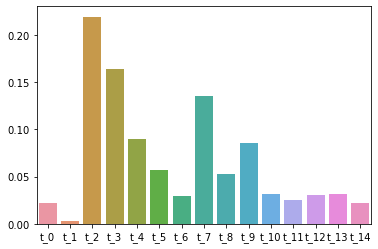

In [5]:
import seaborn
weights = topics.sum() / topics.sum().sum()
seaborn.barplot(weights.index, weights.values)

import matplotlib.pyplot as plt
plt.savefig(f"results/topic_importance.png", bbox_inches='tight')

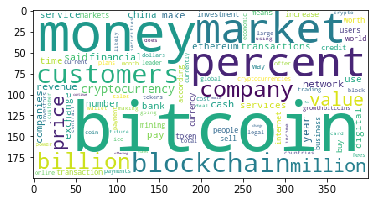

In [6]:
plt.imshow(lda.wordclouds[9])

# Aggregate document topic weights to reflect topic importance over time

Currently the dates have high precision, Need to aggregate them on some other timescale. Lets create some new levels of aggregation 

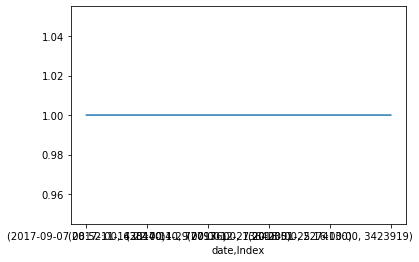

In [7]:
df.groupby("date").Index.value_counts().plot()

In [8]:
print(df.date.dtype)
df.date.sample(2)

object


7383    2017-12-05 21:30:00
6276    2017-11-14 19:07:45
Name: date, dtype: object

In [9]:
# cast dates to date type
df.date = pd.to_datetime(df.date)
print(df.date.dtype)

datetime64[ns]


In [10]:
# Generate frequencies 
freqs = ["Q", "W", "M"]
for freq in freqs:
    df[freq] = df.date.dt.to_period(freq).dt.to_timestamp(freq)
    
df.head()

,Index,date,text,title,week,clean_text,topics,Q,W,M
5038,621031,2017-10-26 15:00:54,eBay launches visual search tools that let you...,eBay launches visual search tools that let you...,2017-10-29 00:00:00,ebay launches visual search tools let shop usi...,"[[0.00023068070773087342, 0.000230681014944547...",2017-12-31,2017-10-29,2017-10-31
5039,621032,2017-10-26 00:00:00,Monsanto Attacks Scientists After Studies Show...,Monsanto Attacks Scientists After Studies Show...,2017-10-29 00:00:00,attacks scientists after studies show trouble ...,"[[9.789552235466458e-05, 9.789532091127945e-05...",2017-12-31,2017-10-29,2017-10-31
5040,621035,2017-10-26 14:41:12,"Hard Drive Stats for Q3 2017In Q3 2017, Backbl...",2017 Hard Drive Reliability by Drive Size and ...,2017-10-29 00:00:00,hard drive stats introduced both tb tb hard dr...,"[[0.00011716483042620975, 0.9349475267091567, ...",2017-12-31,2017-10-29,2017-10-31
5041,621036,2017-10-26 15:27:11,This is part 1 of the “How Unreal Renders a Fr...,How Unreal Renders a Frame,2017-10-29 00:00:00,part how renders frame series access part part...,"[[0.00010482192299492113, 0.000104821867032654...",2017-12-31,2017-10-29,2017-10-31
5042,621423,2017-10-26 16:02:00,Boeing builds towards its first space taxi tes...,Boeing builds towards its first space taxi test,2017-10-29 00:00:00,builds towards first space taxi nasa first nam...,"[[0.12240288673422685, 0.0007490649854944252, ...",2017-12-31,2017-10-29,2017-10-31


# add topics to dataframe

In [11]:
date_unit = "M"
df2 = df.join(topics).copy()
df2.head()

,Index,date,text,title,week,clean_text,topics,Q,W,M,...,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14
5038,621031,2017-10-26 15:00:54,eBay launches visual search tools that let you...,eBay launches visual search tools that let you...,2017-10-29 00:00:00,ebay launches visual search tools let shop usi...,"[[0.00023068070773087342, 0.000230681014944547...",2017-12-31,2017-10-29,2017-10-31,...,0.000231,0.000231,0.000231,0.000231,0.018042,0.083274,0.000231,0.000231,0.848720,0.000231
5039,621032,2017-10-26 00:00:00,Monsanto Attacks Scientists After Studies Show...,Monsanto Attacks Scientists After Studies Show...,2017-10-29 00:00:00,attacks scientists after studies show trouble ...,"[[9.789552235466458e-05, 9.789532091127945e-05...",2017-12-31,2017-10-29,2017-10-31,...,0.254013,0.000098,0.200182,0.000098,0.015392,0.000098,0.000098,0.000098,0.000098,0.000098
5040,621035,2017-10-26 14:41:12,"Hard Drive Stats for Q3 2017In Q3 2017, Backbl...",2017 Hard Drive Reliability by Drive Size and ...,2017-10-29 00:00:00,hard drive stats introduced both tb tb hard dr...,"[[0.00011716483042620975, 0.9349475267091567, ...",2017-12-31,2017-10-29,2017-10-31,...,0.000117,0.000117,0.000117,0.000117,0.024282,0.000117,0.000117,0.000117,0.000117,0.000117
5041,621036,2017-10-26 15:27:11,This is part 1 of the “How Unreal Renders a Fr...,How Unreal Renders a Frame,2017-10-29 00:00:00,part how renders frame series access part part...,"[[0.00010482192299492113, 0.000104821867032654...",2017-12-31,2017-10-29,2017-10-31,...,0.334402,0.000105,0.000105,0.048083,0.000105,0.000105,0.000105,0.008773,0.576966,0.000105
5042,621423,2017-10-26 16:02:00,Boeing builds towards its first space taxi tes...,Boeing builds towards its first space taxi test,2017-10-29 00:00:00,builds towards first space taxi nasa first nam...,"[[0.12240288673422685, 0.0007490649854944252, ...",2017-12-31,2017-10-29,2017-10-31,...,0.078869,0.000749,0.769269,0.000749,0.000749,0.000749,0.000749,0.021220,0.000749,0.000749


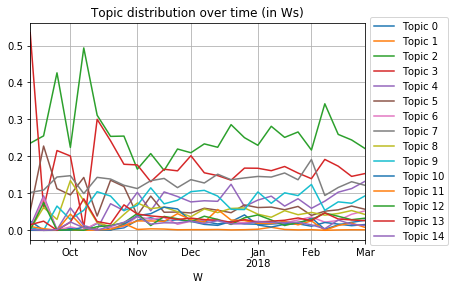

In [23]:
ewmspan=1
date_unit = "W"
#fig, ax = plt.subplots()
topic_columns = df2.filter(like="t_").columns.values
df2.groupby(date_unit)[topic_columns].mean().ewm(span=ewmspan).mean().plot()

# style graph
plt.legend([f"Topic {i}" for i in range(lda.n_components)], loc='center left', bbox_to_anchor=(1, 0.5), )
plt.title(f"Topic distribution over time (in {date_unit}s)")
plt.grid()
plt.savefig(f"results/topic_timeline.png", bbox_inches='tight')

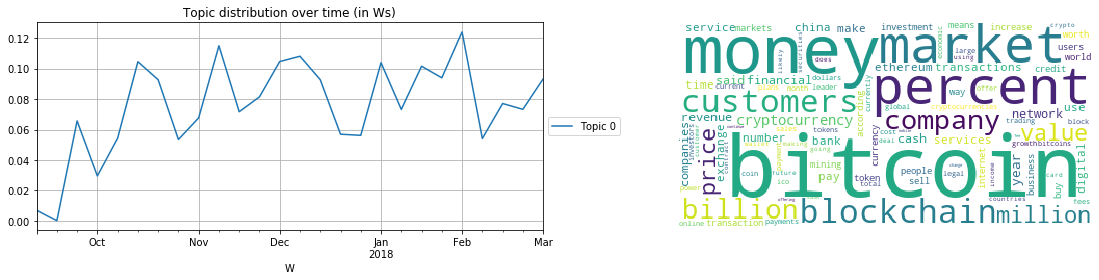

In [31]:
topic_columns = df2.filter(like="t_9").columns.values
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
df2.groupby(date_unit)[topic_columns].mean().ewm(span=ewmspan).mean().plot(ax=ax1)
ax2.imshow(lda.wordclouds[9])
ax2.axis("off")
# style graph
ax1.legend([f"Topic {i}" for i in range(lda.n_components)], loc='center left', bbox_to_anchor=(1, 0.5), )
ax1.set_title(f"Topic distribution over time (in {date_unit}s)")
ax1.grid()
plt.savefig(f"results/topic_timeline.png", bbox_inches='tight')
plt.tight_layout()

# Match with other Time series

In [95]:
ts = pd.read_csv("data/ETH-USD.tsv", sep="\t")
ts["date"] = pd.to_datetime(ts['time'], unit="s")
ts["week"] = ts.date.dt.to_period("W").dt.to_timestamp("W")

ts.head()

,time,low,high,open,close,volume,date,week
0,1497196800,333.43,339.66,336.58,338.73,22887.57,2017-06-11 16:00:00,2017-06-11
1,1497200400,338.36,342.49,338.73,342.16,17959.55,2017-06-11 17:00:00,2017-06-11
2,1497204000,341.78,348.53,342.16,348.43,28182.27,2017-06-11 18:00:00,2017-06-11
3,1497207600,343.80,348.59,348.43,346.23,23394.43,2017-06-11 19:00:00,2017-06-11
4,1497211200,345.62,348.62,346.23,347.29,17382.68,2017-06-11 20:00:00,2017-06-11


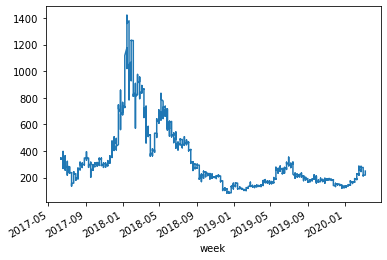

In [96]:
ts.set_index('week')["close"].plot()

In [97]:
topics_w = topics.join(df.week)
joined = topics_w.groupby("week").t_9.agg(["mean"]).join(ts.groupby('week')['close'].last(), rsuffix="_")
joined.head()

,mean,close
week,,
2017-09-10,0.006079,299.21
2017-09-17,0.000077,258.40
2017-09-24,0.065526,282.60
2017-10-01,0.038731,303.95
2017-10-08,0.050292,309.49


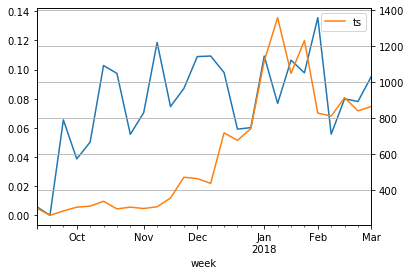

In [98]:
ax = joined['mean'].plot(label="lda")
joined['close'].plot(ax=ax, secondary_y=True, label="ts")
plt.legend()
plt.grid()

# Test for Granger Causality

In [99]:
from statsmodels.tsa.stattools import grangercausalitytests

gcres = grangercausalitytests(joined.values, maxlag=7)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6211  , p=0.2162  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=1.8421  , p=0.1747  , df=1
likelihood ratio test: chi2=1.7774  , p=0.1825  , df=1
parameter F test:         F=1.6211  , p=0.2162  , df_denom=22, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8779  , p=0.4319  , df_denom=19, df_num=2
ssr based chi2 test:   chi2=2.2178  , p=0.3299  , df=2
likelihood ratio test: chi2=2.1212  , p=0.3462  , df=2
parameter F test:         F=0.8779  , p=0.4319  , df_denom=19, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5349  , p=0.6650  , df_denom=16, df_num=3
ssr based chi2 test:   chi2=2.3067  , p=0.5112  , df=3
likelihood ratio test: chi2=2.1983  , p=0.5323  , df=3
parameter F test:         F=0.5349  , p=0.6650  , df_denom=16, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8079  , p=0.1875  , df_d